In [383]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import pyarrow.parquet as pq
from tqdm.notebook import tqdm
from sklearn.feature_selection import f_classif
import pyarrow as pa
import pickle
np.random.seed(42)

In [205]:
fts = pd.read_parquet(r'C:\Users\Эвелина Новикова\fts.parquet')
sol = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_SOLUSDT.parquet')

In [5]:
fts.head()

,mid,diff_mid,sigma,spread,vol_ratio,imb_5,impulse,vwap_5,diff_ratio,ofi,vol_ask_rat,vol_bid_rat,eth,btc,pepe,mew
local_timestamp,,,,,,,,,,,,,,,,
2024-11-01 00:00:04.100,168.625,0.00,0.004216,0.01,0.324650,0.154263,-0.109914,0.999966,0.000000,-1.0,0.004614,0.000000,2518.375,70321.95,0.009116,0.009051
2024-11-01 00:00:04.200,168.625,0.00,0.004216,0.01,0.324650,0.049390,-0.104873,0.999987,0.000000,1.0,0.000000,0.002401,2518.375,70321.95,0.009118,0.009053
2024-11-01 00:00:04.300,168.635,0.01,0.004216,0.01,0.324651,0.082755,0.033366,1.000011,0.333333,0.0,0.000000,0.000000,2518.365,70321.95,0.009118,0.009053
2024-11-01 00:00:04.400,168.635,0.00,0.004216,0.01,0.324651,0.091360,0.008605,1.000001,0.000000,1.0,0.000000,0.000013,2518.285,70321.95,0.009117,0.009054
2024-11-01 00:00:04.500,168.635,0.00,0.004216,0.01,0.324651,-0.028631,-0.119991,1.000011,0.000000,0.0,0.000000,0.000000,2518.185,70317.65,0.009117,0.009056


In [398]:
X = pd.DataFrame({
    'btc' : fts['btc'].shift(5),
    'mew' : fts['mew'].shift(4),
    'eth' : fts['eth'].shift(2),
    'pepe' : fts['pepe'].shift(1),
    'lags_mid' : fts['mid'].shift(1),
    'diff_mid' : fts['diff_mid'].shift(1),
    'sigma' : fts['sigma'].shift(1),
    'spread' : fts['spread'].shift(1),
    'vol_ratio' : fts['vol_ratio'].shift(1),
    'imb' : fts['imb_5'].shift(1),
    'impulse' : fts['impulse'].shift(1),
    'vwap' : fts['vwap_5'].shift(1),
    'diff_ratio' : fts['diff_ratio'].shift(1),
    'ofi' : fts['ofi'].shift(1),
    'vol_ask_rat' : fts['vol_ask_rat'].shift(1),
    'vol_bid_rat' : fts['vol_bid_rat'].shift(1),
})

X = X.dropna()
y = fts['mid'].reindex(X.index)
valid_idx = y.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

### Feature Selection

Так как для предсказаний использоваться будут только линейные модели, отбор фичей будет произведён по результатам ANOVA-теста.

In [395]:
f_scores, p_values = f_classif(X, y)
f_df = pd.DataFrame({
    'feature': X.columns,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)


print("ANOVA F-scores:")
print(f_df)

ANOVA F-scores:
        feature       f_score  p_value
4      lags_mid  4.946964e+07      0.0
3          pepe  3.734757e+03      0.0
2           eth  2.781253e+03      0.0
0           btc  2.397639e+03      0.0
1           mew  4.645253e+02      0.0
7        spread  1.750726e+02      0.0
8     vol_ratio  1.093370e+02      0.0
11         vwap  6.864494e+01      0.0
9           imb  4.985663e+01      0.0
6         sigma  3.706010e+01      0.0
14  vol_ask_rat  1.990575e+01      0.0
15  vol_bid_rat  1.224143e+01      0.0
12   diff_ratio  9.577617e+00      0.0
5      diff_mid  8.991398e+00      0.0
13          ofi  4.275247e+00      0.0
10      impulse  3.291547e+00      0.0


Все фичи идут в модель.

In [400]:
in_sample_start = '2024-11-01 00:00:04.600'
in_sample_end = '2024-11-01 20:00:00.000'

X_train = X.loc[in_sample_start:in_sample_end]
y_train = y.loc[in_sample_start:in_sample_end]
X_test = X.loc[in_sample_end:]
y_test = y.loc[in_sample_end:]

### Scaling

In [402]:
#  Масштабирование признаков
scaler = StandardScaler()
# fit and transform 
X_train_scaled = scaler.fit_transform(X_train)
# применение уже обученного scaler'а
X_test_scaled = scaler.transform(X_test)

### ML

Нам критически важна скорость, поэтому будут использованы только простые линейные модели с регуляризацией: Passive-Agressive Regression, Ridge Regression и стохастический градиентный спуск. У каждой из них есть преимущества в плане скорости обучения. Настройка параметров будет, во-первых, исходя из результатов на треине и тесте 100 случайных значений параметра и, во-вторых, с помощью GridSearch. Лучшая модель будет выбрана по MAPE.

### 1. Passive-Agressive Regression

In [404]:
np.random.seed(42)
n_C = 100
Cs = np.logspace(-3, 0, n_C)

coefs_pa_1 = []
mape_train_pa_1 = []
mape_test_pa_1 = []

for i, a in enumerate(Cs):
    if i % 10 == 0:
        print(f"Processing {i+1}/{len(Cs)}, C = {a:.6f}")
    par = PassiveAggressiveRegressor(C=a, early_stopping=True, random_state=42)
    par.fit(X_train_scaled, y_train)
    coefs_pa_1.append(par.coef_)
    mape_train_pa_1.append(mean_absolute_percentage_error(y_train, par.predict(X_train_scaled)))
    mape_test_pa_1.append(mean_absolute_percentage_error(y_test, par.predict(X_test_scaled)))

Processing 1/100, C = 0.001000
Processing 11/100, C = 0.002009
Processing 21/100, C = 0.004037
Processing 31/100, C = 0.008111
Processing 41/100, C = 0.016298
Processing 51/100, C = 0.032745
Processing 61/100, C = 0.065793
Processing 71/100, C = 0.132194
Processing 81/100, C = 0.265609
Processing 91/100, C = 0.533670


In [405]:
finally_C = Cs[np.argmin(mape_test_pa_1)]

(1.4125375446227544,
 0.000707945784384138,
 3.8772286277259874e-05,
 0.0002283738364367767)

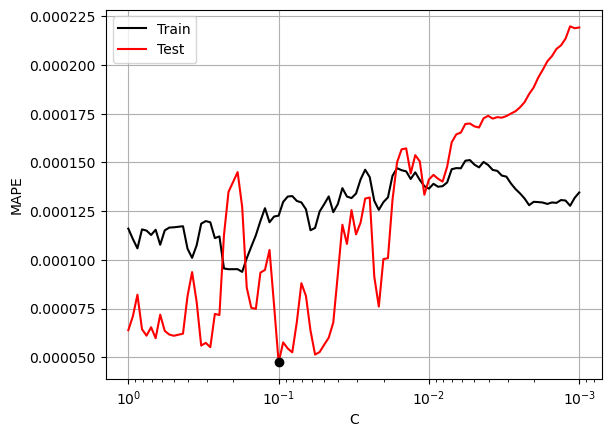

In [406]:
ax = plt.gca()

ax.plot(Cs, mape_train_pa_1, label = 'Train', color = 'black')
ax.plot(Cs, mape_test_pa_1, label = 'Test', color = 'red')

ax.plot(finally_C, mape_test_pa_1[np.argmin(mape_test_pa_1)], 'o', color = 'black')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("C")
plt.ylabel("MAPE")
plt.axis("tight")


In [407]:
np.random.seed(42)
n_eps = 100
epss = np.logspace(0.0001, 1, n_eps)

coefs_pa_2 = []
mape_train_pa_2 = []
mape_test_pa_2 = []

for i, a in enumerate(epss):
    if i % 10 == 0:
        print(f"Processing {i+1}/{len(Cs)}, Epsilon = {a:.6f}")
    par = PassiveAggressiveRegressor(C = finally_C, epsilon = a, early_stopping = True, random_state = 42)
    par.fit(X_train_scaled, y_train)
    coefs_pa_2.append(par.coef_)
    mape_train_pa_2.append(mean_absolute_percentage_error(y_train, par.predict(X_train_scaled)))
    mape_test_pa_2.append(mean_absolute_percentage_error(y_test, par.predict(X_test_scaled)))

Processing 1/100, Epsilon = 1.000230
Processing 11/100, Epsilon = 1.262118
Processing 21/100, Epsilon = 1.592575
Processing 31/100, Epsilon = 2.009555
Processing 41/100, Epsilon = 2.535712
Processing 51/100, Epsilon = 3.199632
Processing 61/100, Epsilon = 4.037383
Processing 71/100, Epsilon = 5.094482
Processing 81/100, Epsilon = 6.428357
Processing 91/100, Epsilon = 8.111478


In [408]:
finally_eps = epss[np.argmin(mape_test_pa_2)]

(11.220055366614888,
 0.8914664432022282,
 0.00029723770100389415,
 0.03228213608230225)

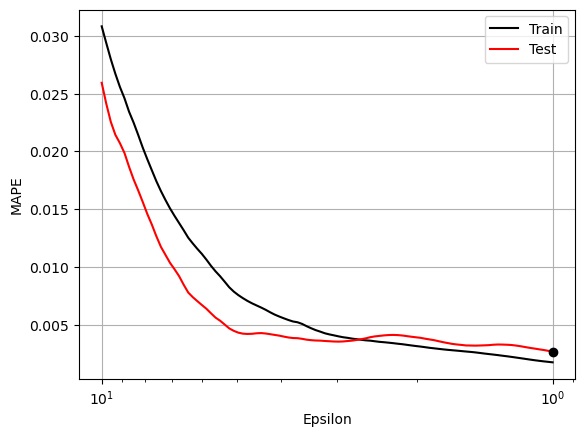

In [409]:
ax = plt.gca()

ax.plot(epss, mape_train_pa_2, label = 'Train', color = 'black')
ax.plot(epss, mape_test_pa_2, label = 'Test', color = 'red')

ax.plot(finally_eps, mape_test_pa_2[np.argmin(mape_test_pa_2)], 'o', color = 'black')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Epsilon")
plt.ylabel("MAPE")
plt.axis("tight")


In [410]:
param_grid_pa = {
    'passiveaggressiveregressor__C': [finally_C, 0.01, 0.1, 1.0, 10.0],
    'passiveaggressiveregressor__epsilon': [finally_eps, 1e-5, 1e-4, 5e-4, 1e-3],
    'passiveaggressiveregressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'passiveaggressiveregressor__early_stopping': [True, False],
    'passiveaggressiveregressor__tol': [1e-4, 1e-3, 1e-2]
}

pipeline_pa = make_pipeline(
    StandardScaler(),
    PassiveAggressiveRegressor(max_iter=1000, C = finally_C, epsilon = finally_eps, random_state=42)
)

gscv_pa = GridSearchCV(pipeline_pa, param_grid_pa, cv=TimeSeriesSplit(n_splits=3),
                    scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

gscv_pa.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('passiveaggressiveregressor',
                                        PassiveAggressiveRegressor(C=0.1,
                                                                   epsilon=1.0002302850208247,
                                                                   random_state=42))]),
             n_jobs=-1,
             param_grid={'passiveaggressiveregressor__C': [0.1, 0.01, 0.1, 1.0,
                                                           10.0],
                         'passiveaggressiveregressor__early_stopping': [True,
                                                                        False],
                         'passiveaggressiveregressor__epsilon': [1.0002302850208247,
                                                                 1e-05, 0.0001,
                                                                 0.0005,
                                                                 0.001],
                         'passiveaggressiveregressor__loss': ['epsilon_insensitive',
                                                              'squared_epsilon_insensitive'],
                         'passiveaggressiveregressor__tol': [0.0001, 0.001,
                                                             0.01]},
             scoring='neg_mean_absolute_percentage_error')

### 2. Ridge Regression

In [411]:
n_alphas_ridge = 100
alphas_ridge = np.logspace(-5, 5, n_alphas_ridge)

coefs_ridge = []   
mape_train_ridge = [] 
mape_test_ridge = [] 

for i, a in enumerate(alphas_ridge):
    if i % 10 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_train_scaled, y_train)
    coefs_ridge.append(ridge.coef_)
    mape_train_ridge.append(mean_absolute_percentage_error(y_train, ridge.predict(X_train_scaled)))
    mape_test_ridge.append(mean_absolute_percentage_error(y_test, ridge.predict(X_test_scaled)))

Processing 1/100, Alpha = 0.000010
Processing 11/100, Alpha = 0.000102
Processing 21/100, Alpha = 0.001048
Processing 31/100, Alpha = 0.010723
Processing 41/100, Alpha = 0.109750
Processing 51/100, Alpha = 1.123324
Processing 61/100, Alpha = 11.497570
Processing 71/100, Alpha = 117.681195
Processing 81/100, Alpha = 1204.503540
Processing 91/100, Alpha = 12328.467394


In [412]:
finally_alpha_ridge = alphas_ridge[np.argmin(mape_test_ridge)]

(316227.7660168379,
 3.162277660168379e-06,
 -5.0853890947258484e-05,
 0.0012477050453551003)

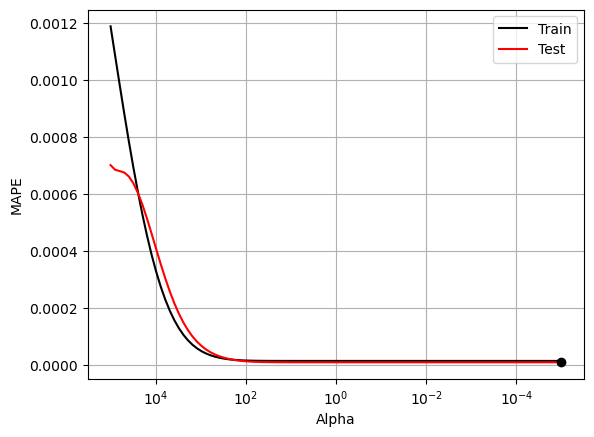

In [413]:
ax = plt.gca()

ax.plot(alphas_ridge, mape_train_ridge, label = 'Train', color = 'black')
ax.plot(alphas_ridge, mape_test_ridge, label = 'Test', color = 'red')

ax.plot(finally_alpha_ridge, mape_test_ridge[np.argmin(mape_test_ridge)], 'o', color = 'black')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAPE")
plt.axis("tight")


In [414]:
param_grid_ridge = {
    'ridge__alpha': [finally_alpha, 0.001, 0.01, 0.1, 1, 10, 100],
    'ridge__fit_intercept': [True, False]
}

pipeline_ridge = make_pipeline(
    StandardScaler(),
    Ridge(max_iter=1000,tol=1e-4, random_state=42)
)

gscv_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=TimeSeriesSplit(n_splits=3),
                    scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

gscv_ridge.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge',
                                        Ridge(max_iter=1000,
                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.22051307399030456, 0.001, 0.01, 0.1,
                                          1, 10, 100],
                         'ridge__fit_intercept': [True, False]},
             scoring='neg_mean_absolute_percentage_error')

### 3. SGD Regression

In [415]:
n_alphas_sgd = 100
alphas_sgd = np.logspace(-3, 3, n_alphas_sgd)
coefs_sgd = []   
mape_train_sgd = [] 
mape_test_sgd = [] 

for i, a in enumerate(alphas_sgd):
    if i % 10 == 0:
        print(f"Processing {i+1}/{len(alphas_sgd)}, Alpha = {a:.6f}")
    sgd = SGDRegressor(alpha = a, early_stopping=True, random_state=42)
    sgd.fit(X_train_scaled, y_train)
    coefs_sgd.append(sgd.coef_)
    mape_train_sgd.append(mean_absolute_percentage_error(y_train, sgd.predict(X_train_scaled)))
    mape_test_sgd.append(mean_absolute_percentage_error(y_test, sgd.predict(X_test_scaled)))

Processing 1/100, Alpha = 0.001000
Processing 11/100, Alpha = 0.004037
Processing 21/100, Alpha = 0.016298
Processing 31/100, Alpha = 0.065793
Processing 41/100, Alpha = 0.265609
Processing 51/100, Alpha = 1.072267
Processing 61/100, Alpha = 4.328761
Processing 71/100, Alpha = 17.475284
Processing 81/100, Alpha = 70.548023
Processing 91/100, Alpha = 284.803587


In [416]:
finally_alpha_sgd = alphas_sgd[np.argmin(mape_test_sgd)]

(1995.2623149688789,
 0.0005011872336272725,
 -0.0005247881276472043,
 0.011980125533659248)

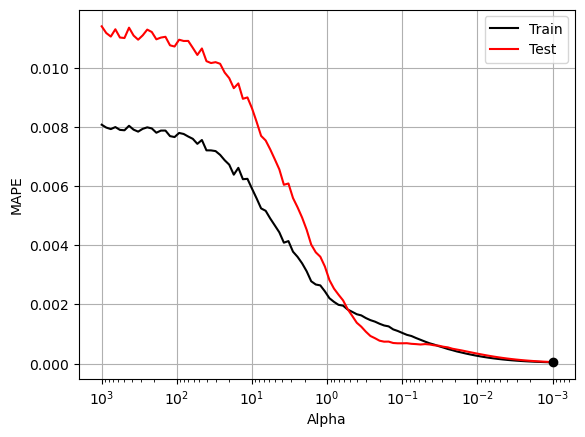

In [417]:
ax = plt.gca()

ax.plot(alphas_sgd, mape_train_sgd, label = 'Train', color = 'black')
ax.plot(alphas_sgd, mape_test_sgd, label = 'Test', color = 'red')

ax.plot(finally_alpha_sgd, mape_train_sgd[np.argmin(mape_train_sgd)], 'o', color = 'black')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAPE")
plt.axis("tight")


In [418]:
param_grid_sgd = {
    'sgdregressor__alpha': [finally_alpha_sgd, 0.01, 0.1, 1],
    'sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdregressor__epsilon': [0.1, 0.5, 1.0]
}


pipeline_sgd = make_pipeline(
    StandardScaler(),
    SGDRegressor(
        random_state=42,
        max_iter=1000,
        tol=1e-3,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5
    )
)


gscv_sgd = GridSearchCV(
    pipeline_sgd, 
    param_grid_sgd, 
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_percentage_error', 
    n_jobs=-1,
    verbose=1
)


gscv_sgd.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdregressor',
                                        SGDRegressor(early_stopping=True,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [0.001, 0.01, 0.1, 1],
                         'sgdregressor__epsilon': [0.1, 0.5, 1.0],
                         'sgdregressor__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [442]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Sign Accuracy': np.mean(np.sign(np.diff(y_pred)) == np.sign(np.diff(y_test.to_numpy())))
    }

# Собираем оценки
results = []

# PAR
best_pa_model = gscv_pa.best_estimator_
results.append(evaluate_model("PassiveAggressive", best_pa_model, X_test, y_test))

# SGD
best_sgd_model = gscv_sgd.best_estimator_
results.append(evaluate_model("SGDRegressor", best_sgd_model, X_test, y_test))

# Ridge Regression
best_ridge_model = gscv_ridge.best_estimator_
results.append(evaluate_model("Ridge", best_rigde_model, X_test, y_test))


results_df = pd.DataFrame(results).sort_values(by='MAPE').reset_index(drop=True)
print(results_df.to_string(index=True))

               Model      MAPE       MAE        R2  Sign Accuracy
0              Ridge  0.000008  0.001353  0.999980       0.047740
1       SGDRegressor  0.000010  0.001670  0.999975       0.779017
2  PassiveAggressive  0.000014  0.002267  0.999961       0.047303


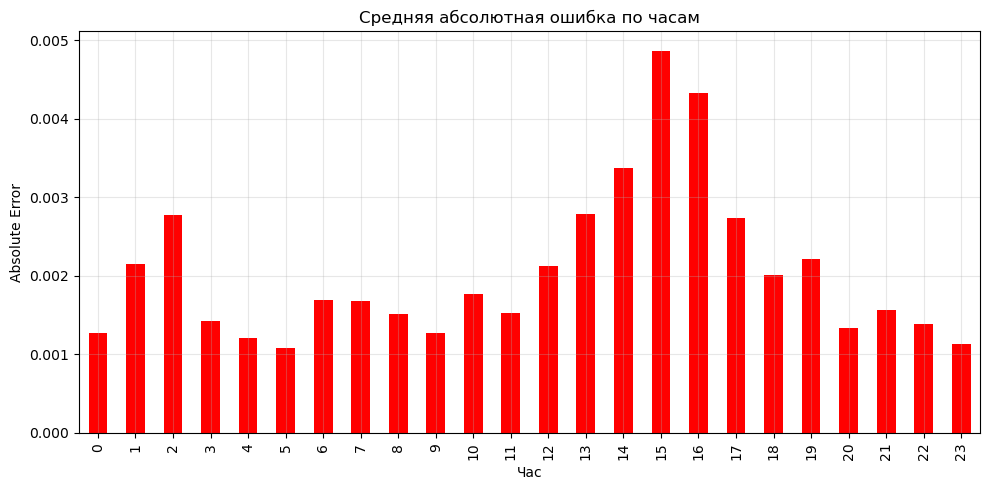

In [444]:
y_full_pred = best_ridge_model.predict(X)

# Формируем DataFrame с результатами
result = pd.DataFrame({
    'predicted_mid_t': y_full_pred,
    'actual': y.values,
}, index=X.index)

# Вычисляем ошибки и добавляем временные метки
result['abs_error'] = np.abs(result['predicted_mid_t'] - result['actual'])
result['hour'] = result.index.hour

# Визуализация: ошибка по часам
result.groupby('hour')['abs_error'].mean().plot(
    kind='bar',
    title='Средняя абсолютная ошибка по часам',
    ylabel='Absolute Error',
    xlabel='Час',
    figsize=(10, 5),
    color='red'
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [448]:
# Сохранение результатов
pq.write_table(pa.Table.from_pandas(result), 'pa_model_results.parquet')

In [450]:
result.head()

,predicted_mid_t,actual,abs_error,hour
local_timestamp,,,,
2024-11-01 00:00:04.600,168.634096,168.635,0.000904,0
2024-11-01 00:00:04.700,168.634278,168.635,0.000722,0
2024-11-01 00:00:04.800,168.637029,168.635,0.002029,0
2024-11-01 00:00:04.900,168.634445,168.635,0.000555,0
2024-11-01 00:00:05.000,168.637079,168.635,0.002079,0


In [452]:
mid_price = result['predicted_mid_t'].values
timestamps = result.index

In [454]:
sol['mid'] = (sol['asks[0].price'] + sol['bids[0].price'])/2
sol['local_timestamp'] = pd.to_datetime(sol['local_timestamp'], unit='us')

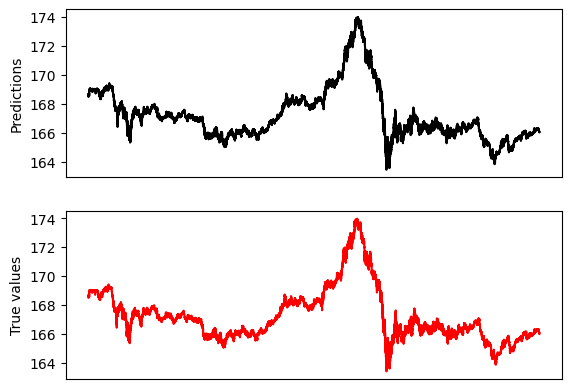

In [456]:
fig, (ax1, ax2) = plt.subplots(2, 1)


ax1.plot(mid_price, color='black')
ax1.set_ylabel('Predictions')
ax1.set_xticks([])

ax2.plot(sol['mid'], color='red')
ax2.set_ylabel('True values')
ax2.set_xticks([])

plt.show()

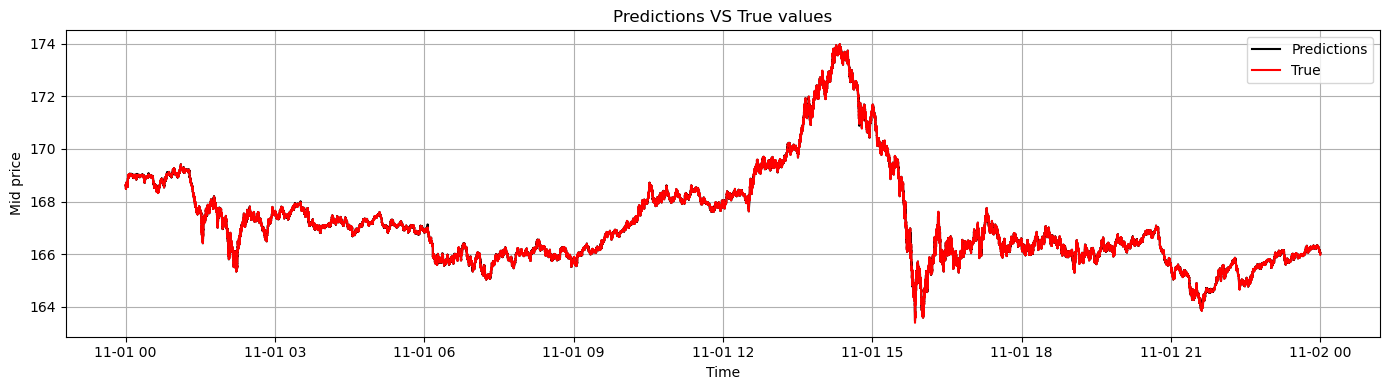

In [458]:
plt.figure(figsize=(14, 4))
plt.plot(timestamps, mid_price, color='black', label = 'Predictions')
plt.plot(sol['local_timestamp'], sol['mid'], color='red', label = 'True')
plt.title("Predictions VS True values")
plt.xlabel("Time")
plt.ylabel("Mid price")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# сохраняем лучшую модель 
with open('ridge_for_hft.pkl', 'wb') as file:
    pickle.dump(best_ridge_model, file)